In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import numpy as np
import pandas as pd

from sklearn.metrics import confusion_matrix, classification_report

import sys
sys.path.append('../lib/')
from blood_lib import learning_curves

import tensorflow as tf
import tensorflow_addons as tfa

## Training a simple model called BNet

In [2]:
path = '../Data/PBC_6cat/'

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    path,
    image_size=(128, 128),
    labels='inferred',
    interpolation='bicubic',
    label_mode='categorical',
    validation_split=0.20,
    batch_size=32,
    subset='both',
    shuffle=True,
    seed=1
)
class_names = train_ds.class_names
num_classes = len(class_names)
train_ds, test_ds = tf.keras.utils.split_dataset(
    train_ds, left_size=0.8, seed=1)
print('train batch :', tf.data.Dataset.cardinality(train_ds).numpy())
print('val batch :', tf.data.Dataset.cardinality(val_ds).numpy())
print('test batch :', tf.data.Dataset.cardinality(test_ds).numpy())
print('classes :', class_names)
print('num_classes :', num_classes)


Found 10868 files belonging to 6 classes.
Using 8695 files for training.
Using 2173 files for validation.
Metal device set to: AMD Radeon Pro 570

systemMemory: 40.00 GB
maxCacheSize: 2.00 GB



2023-06-11 16:08:14.813129: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-06-11 16:08:14.813200: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-06-11 16:08:15.407696: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [8695]
	 [[{{node Placeholder/_4}}]]
2023-06-11 16:08:15.408181: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does n

train batch : 218
val batch : 68
test batch : 55
classes : ['basophil', 'eosinophil', 'erythroblast', 'lymphocyte', 'monocyte', 'platelet']
num_classes : 6


Calcul des class weights

In [3]:
# directory = Path(path)
# class_weights = {}
# total = len(list(directory.glob('**/*.png')))
# for i, class_name in enumerate(class_names):
#     #print(i, class_name)
#     len_i = len(list(Path(directory/class_name).glob('*.png')))
#     print(i, len_i)
#     weight_for_i = (1 / len_i) * (total / num_classes)
#     #print(weight_for_i)
#     class_weights[i] = weight_for_i
# class_weights


### Pre-process files

In [4]:
# Random data augmentation
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip(
            "horizontal_and_vertical", input_shape=(128, 128, 3)),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomBrightness(factor=0.001, value_range=(0, 255)),
        tf.keras.layers.RandomContrast(factor=0.1)
    ])


def process_images(ds, shuffle=1000, augment=False):
    """
    Apply diverse images modification in a tf.data.Dataset
    """
    # rescale
    normalization_layer = tf.keras.layers.Rescaling(1./255)
    ds = ds.map(lambda x, y: (normalization_layer(x), y))
    # shuffle
    if shuffle != None:
        ds = ds.shuffle(shuffle)
    # augment
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y))
    return ds


train_ds = process_images(train_ds, shuffle=None, augment=False)
val_ds = process_images(val_ds, shuffle=None, augment=False)
test_ds = process_images(test_ds, shuffle=None, augment=False)


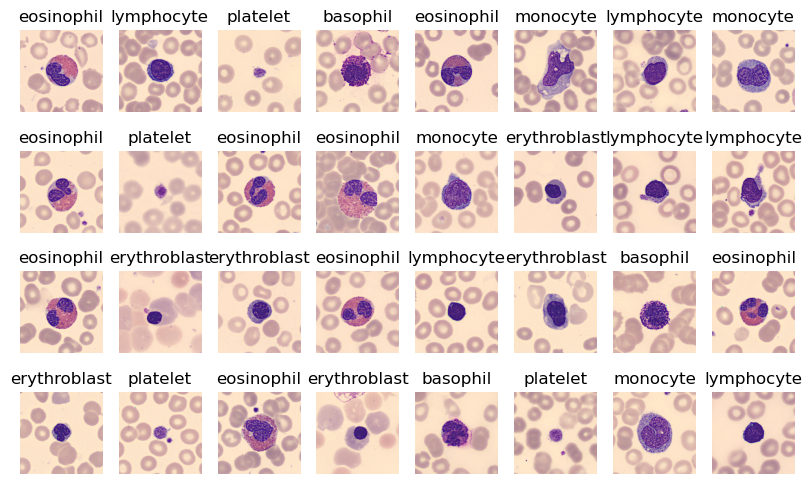

In [17]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 6))
for i in range(32):
    ax = plt.subplot(4, 8, i + 1)
    plt.imshow((image_batch[i].numpy() * 255).astype('uint8'))
    plt.title(class_names[np.argmax(label_batch[i])])
    plt.axis("off")


In [20]:
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from datetime import datetime

model = tf.keras.Sequential([
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

epochs = 50
log_dir = "logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")
callbacks = [EarlyStopping(monitor='val_loss', patience=5),
             TensorBoard(log_dir=log_dir, histogram_freq=1),
             tfa.callbacks.TQDMProgressBar()]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks,
    verbose=0
)


Training:   0%|           0/50 ETA: ?s,  ?epochs/s

Epoch 1/50


0/218           ETA: ?s - 

2023-06-11 16:23:31.961555: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-11 16:23:54.951102: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2173]
	 [[{{node Placeholder/_4}}]]
2023-06-11 16:23:54.951521: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2173]
	 [[{{node Placeholder/_4}}]]
2023-06-11 16:23:55.342967: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 2/50


0/218           ETA: ?s - 

Epoch 3/50


0/218           ETA: ?s - 

Epoch 4/50


0/218           ETA: ?s - 

Epoch 5/50


0/218           ETA: ?s - 

Epoch 6/50


0/218           ETA: ?s - 

Epoch 7/50


0/218           ETA: ?s - 

Epoch 8/50


0/218           ETA: ?s - 

Epoch 9/50


0/218           ETA: ?s - 

Epoch 10/50


0/218           ETA: ?s - 

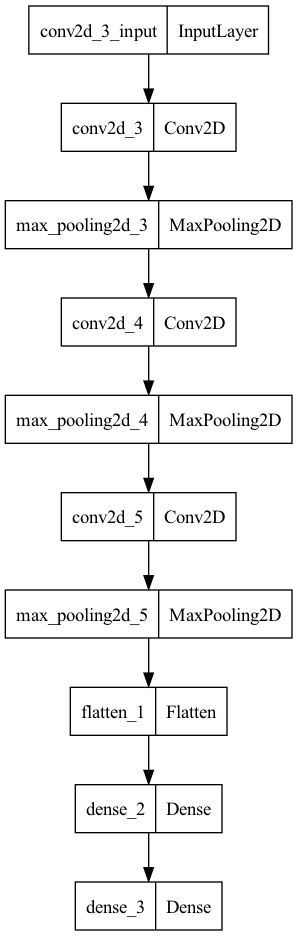

In [21]:
tf.keras.utils.plot_model(model)


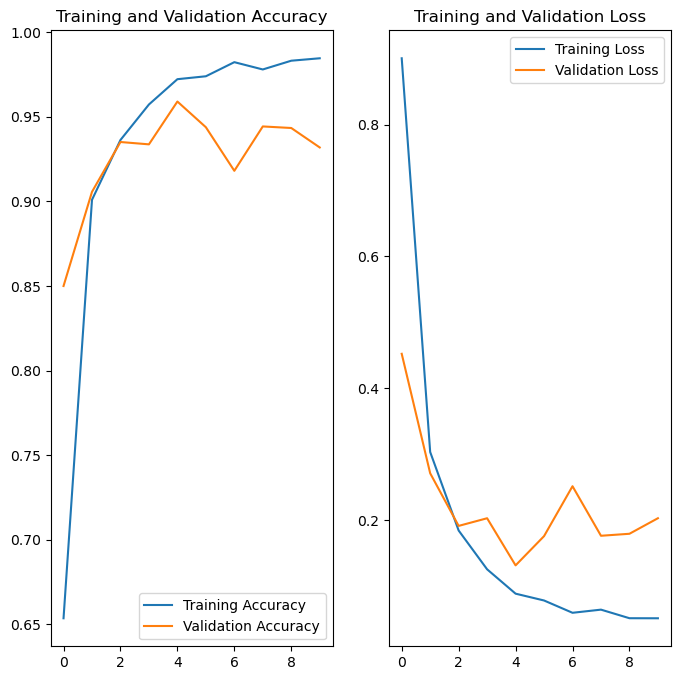

In [22]:
learning_curves(history)


Results on test set

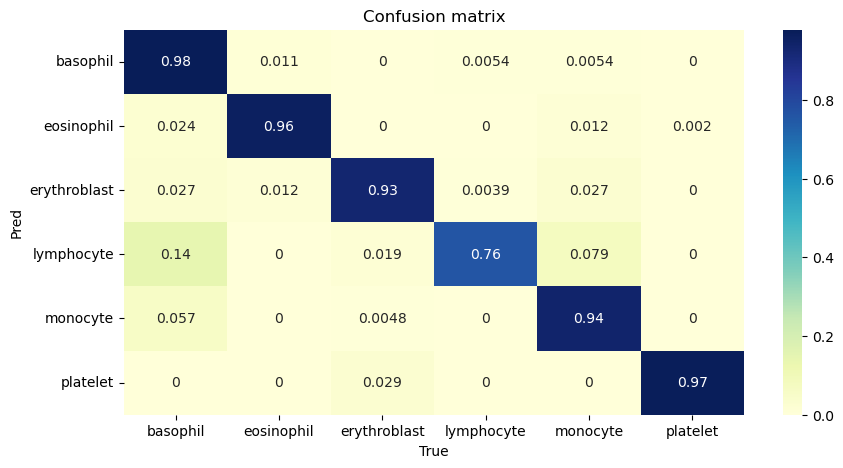

              precision    recall  f1-score   support

    basophil       0.75      0.98      0.85       186
  eosinophil       0.99      0.96      0.98       492
erythroblast       0.94      0.93      0.93       257
  lymphocyte       0.99      0.76      0.86       216
    monocyte       0.86      0.94      0.90       209
    platelet       1.00      0.97      0.98       379

    accuracy                           0.93      1739
   macro avg       0.92      0.92      0.92      1739
weighted avg       0.94      0.93      0.93      1739



In [26]:
preds = model.predict(test_ds, batch_size=32, verbose=0)
preds = np.argmax(preds, axis=1)
true = np.concatenate([y for x, y in test_ds], axis=0)
true = np.argmax(true, axis=1)
preds_labels = [class_names[preds[x]] for x in range(len(preds))]
true_labels = [class_names[true[x]] for x in range(len(true))]

cm = confusion_matrix(true_labels, preds_labels, normalize='true')
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
plt.figure(figsize=(10, 5))
plt.title("Confusion matrix")
sns.heatmap(cm_df, annot=True, cmap="YlGnBu")
plt.ylabel("Pred")
plt.xlabel("True")
plt.show()
CR = classification_report(true_labels, preds_labels)
print(CR)


In [29]:
model.save('Models/M0_PBC6_CNN3L.h5')
with open('CR/CR_PBC6_CNN3L.txt', 'w') as file:
    file.write(CR)
    file.close()
